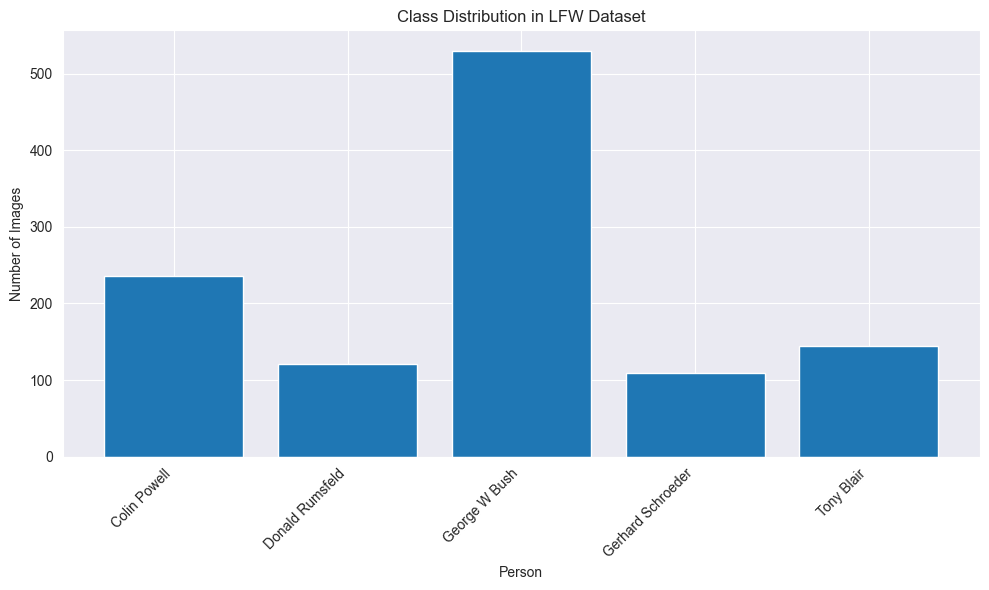

Original samples per class: [236 121 530 109 144]
Balanced samples per class: [109 109 109 109 109]
Total samples: 1140 -> 545
Before balancing - Intra-class variance: 61.51, Inter-class variance: 2.80
After balancing - Intra-class variance: 60.52, Inter-class variance: 2.73


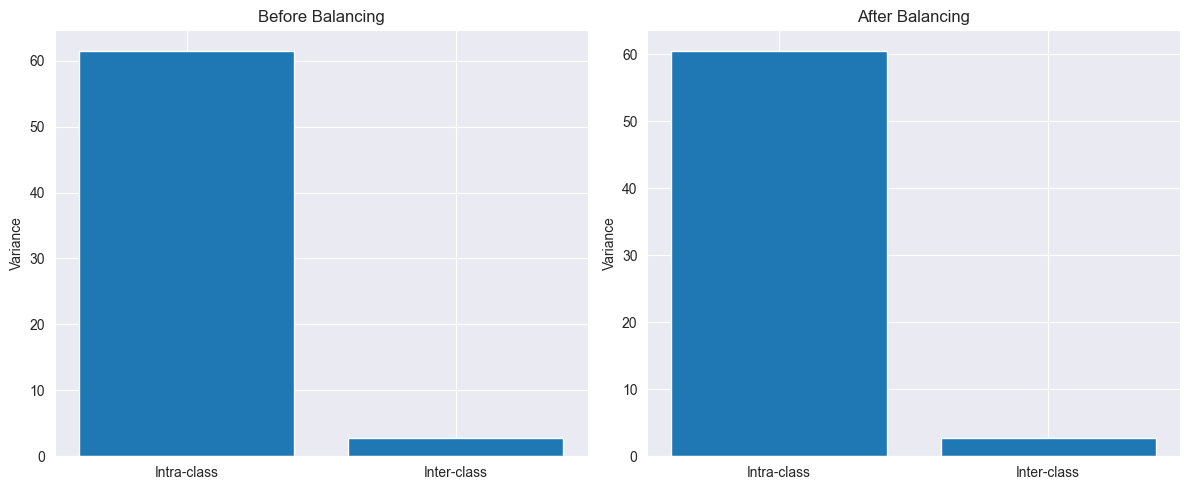

C=0.001: Accuracy=0.2622, Time=0.20s
C=0.01: Accuracy=0.7500, Time=0.16s
C=0.1: Accuracy=0.8049, Time=0.13s
C=1: Accuracy=0.8171, Time=0.14s
C=10: Accuracy=0.8171, Time=0.14s
C=100: Accuracy=0.8171, Time=0.14s

Best C: 1 with accuracy: 0.8171

Best Linear SVM Results (C=1):
Accuracy: 0.8171
Training Time: 0.14s
Confusion Matrix:
[[21  2  6  1  0]
 [ 3 26  2  0  0]
 [ 0  1 28  1  0]
 [ 0  1  2 31  4]
 [ 2  2  1  2 28]]


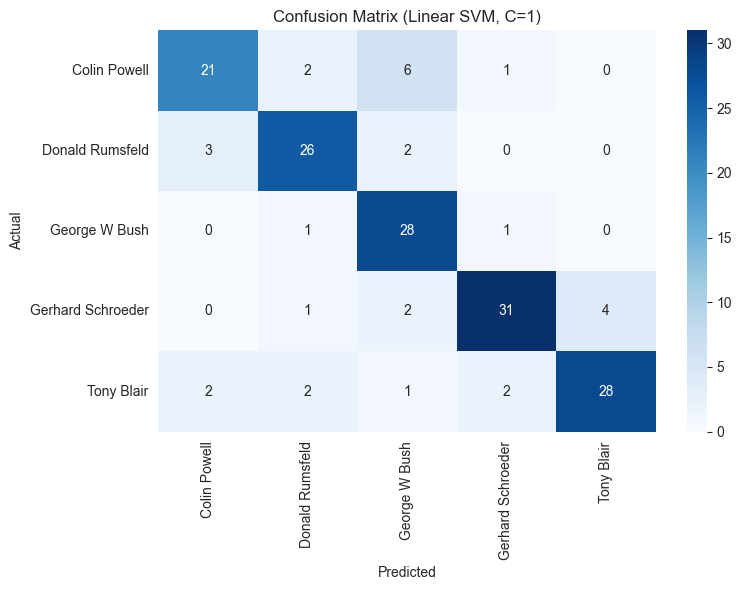

Kernel=poly: Accuracy=0.7927, Time=0.14s
Kernel=rbf: Accuracy=0.7073, Time=0.19s
Kernel=sigmoid: Accuracy=0.1829, Time=0.20s


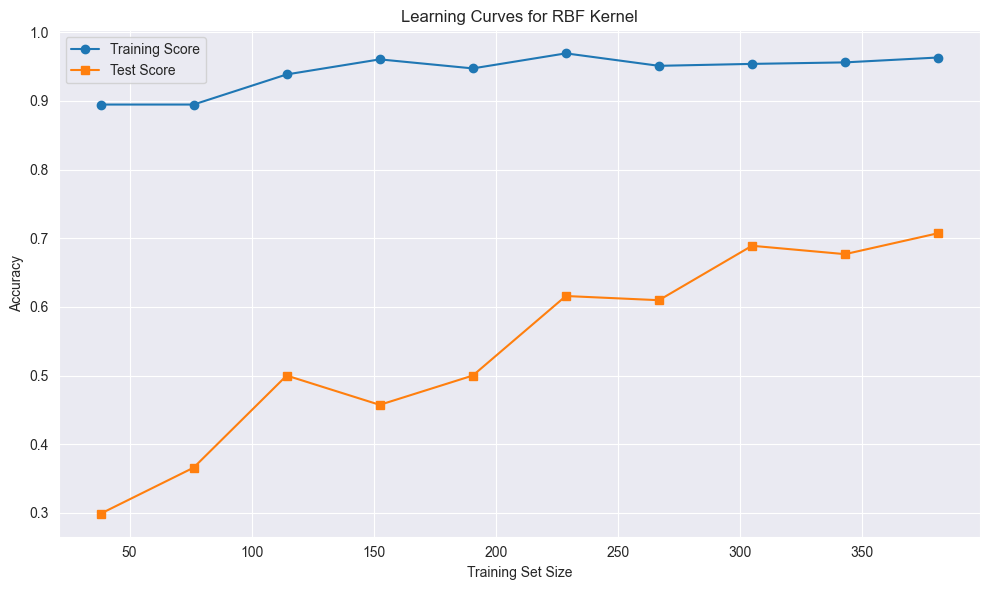

Gamma=0.0001: Test Accuracy=0.2195
Gamma=0.001: Test Accuracy=0.3354
Gamma=0.01: Test Accuracy=0.7256
Gamma=0.1: Test Accuracy=0.3537
Gamma=1: Test Accuracy=0.1829


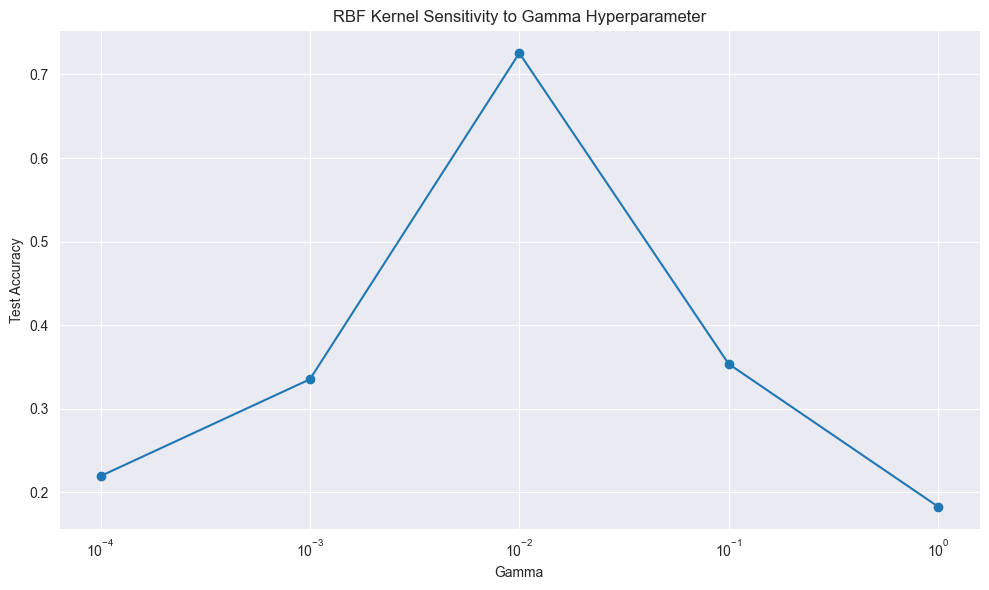

In [17]:
from sklearn.datasets import fetch_lfw_people
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import seaborn as sns

faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] * faces.images.shape[2])



unique, counts = np.unique(faces.target, axis=0, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(range(len(unique)), counts)
plt.xticks(range(len(unique)), faces.target_names[unique], rotation=45, ha='right')
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Class Distribution in LFW Dataset')
plt.tight_layout()
plt.show()

min_samples = np.min(counts)
balanced_indices = []
for i in unique:
    class_indices = np.where(faces.target == i)[0]
    selected = np.random.choice(class_indices, min_samples, replace=False)
    balanced_indices.extend(selected)

balanced_indices = np.array(balanced_indices)
np.random.shuffle(balanced_indices)

X_balanced = faces.data[balanced_indices]
y_balanced = faces.target[balanced_indices]

unique_balanced, counts_balanced = np.unique(y_balanced, return_counts=True)
print(f"Original samples per class: {counts}")
print(f"Balanced samples per class: {counts_balanced}")
print(f"Total samples: {len(faces.data)} -> {len(X_balanced)}")

def compute_class_variance(X, y):
    intra_class = []
    for label in np.unique(y):
        class_data = X[y == label]
        class_mean = np.mean(class_data, axis=0)
        variance = np.mean(np.sum((class_data - class_mean) ** 2, axis=1))
        intra_class.append(variance)

    class_means = []
    for label in np.unique(y):
        class_data = X[y == label]
        class_means.append(np.mean(class_data, axis=0))
    class_means = np.array(class_means)
    overall_mean = np.mean(X, axis=0)
    inter_class = np.mean(np.sum((class_means - overall_mean) ** 2, axis=1))

    return np.mean(intra_class), inter_class

intra_before, inter_before = compute_class_variance(faces.data, faces.target)
intra_after, inter_after = compute_class_variance(X_balanced, y_balanced)

print(f"Before balancing - Intra-class variance: {intra_before:.2f}, Inter-class variance: {inter_before:.2f}")
print(f"After balancing - Intra-class variance: {intra_after:.2f}, Inter-class variance: {inter_after:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(['Intra-class', 'Inter-class'], [intra_before, inter_before])
axes[0].set_title('Before Balancing')
axes[0].set_ylabel('Variance')
axes[1].bar(['Intra-class', 'Inter-class'], [intra_after, inter_after])
axes[1].set_title('After Balancing')
axes[1].set_ylabel('Variance')
plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results = []

for C in C_values:
    start_time = time.time()
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((C, acc, train_time))
    print(f"C={C}: Accuracy={acc:.4f}, Time={train_time:.2f}s")

best_result = max(results, key=lambda x: x[1])
best_C = best_result[0]
print(f"\nBest C: {best_C} with accuracy: {best_result[1]:.4f}")

start_time = time.time()
best_svm = SVC(kernel='linear', C=best_C)
best_svm.fit(X_train, y_train)
best_train_time = time.time() - start_time

y_pred_best = best_svm.predict(X_test)
best_acc = accuracy_score(y_test, y_pred_best)
cm = confusion_matrix(y_test, y_pred_best)

print(f"\nBest Linear SVM Results (C={best_C}):")
print(f"Accuracy: {best_acc:.4f}")
print(f"Training Time: {best_train_time:.2f}s")
print(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=faces.target_names[unique_balanced],
            yticklabels=faces.target_names[unique_balanced])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Linear SVM, C={best_C})')
plt.tight_layout()
plt.show()

kernels = ['poly', 'rbf', 'sigmoid']
kernel_results = []

for kernel in kernels:
    start_time = time.time()
    svm = SVC(kernel=kernel, gamma='scale')
    svm.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kernel_results.append((kernel, acc, train_time))
    print(f"Kernel={kernel}: Accuracy={acc:.4f}, Time={train_time:.2f}s")

train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
test_scores = []

for size in train_sizes:
    n_samples = int(len(X_train) * size)
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]

    svm_rbf = SVC(kernel='rbf', gamma='scale')
    svm_rbf.fit(X_subset, y_subset)

    train_score = svm_rbf.score(X_subset, y_subset)
    test_score = svm_rbf.score(X_test, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * len(X_train), train_scores, label='Training Score', marker='o')
plt.plot(train_sizes * len(X_train), test_scores, label='Test Score', marker='s')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves for RBF Kernel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

gamma_values = [0.0001, 0.001, 0.01, 0.1, 1]
gamma_results = []

for gamma in gamma_values:
    svm_rbf = SVC(kernel='rbf', gamma=gamma)
    svm_rbf.fit(X_train, y_train)
    test_acc = svm_rbf.score(X_test, y_test)
    gamma_results.append(test_acc)
    print(f"Gamma={gamma}: Test Accuracy={test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(gamma_values, gamma_results, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Test Accuracy')
plt.title('RBF Kernel Sensitivity to Gamma Hyperparameter')
plt.grid(True)
plt.tight_layout()
plt.show()